In [51]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# Segmentation data for NIR_1
pupil_xyr = [196.26, 136.09,  42.00]
iris_xyr  = [191.54, 142.90, 118.30]

# Segmentation data for LFVL
pupil_xyr = [  255.9056435, 203.3425754, 51.4965453]
iris_xyr  = [  259.230959, 207.469999, 137.872368]


# Output dilation
dil = 0.2

In [53]:
# # read a png image using opencv
# import cv2 as cv
# # install opencv

# cv_img = cv.imread('x.png', -1)
# cv_img.astype(int)


array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

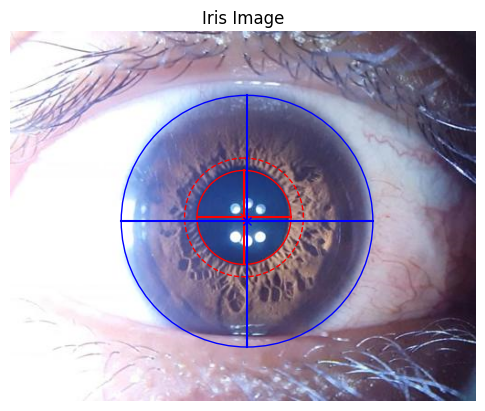

In [54]:
# Open input image
img_name = 'LFVL'
im1 = Image.open('../samples/NIR_1.png')
im1 = Image.open(f'../samples/{img_name}.png')


# plot the pupil_x and pupil_y on the image
plt.imshow(im1, cmap='gray')
plt.plot(pupil_xyr[0], pupil_xyr[1], 'rx')
# plot a line along the x-axis with (pupil_x, pupil_y) as the centre point and pupil_r as the radius
plt.plot([pupil_xyr[0] - pupil_xyr[2], pupil_xyr[0] + pupil_xyr[2]], [pupil_xyr[1], pupil_xyr[1]], 'r')
# plot a perpendicular line along the y-axis with (pupil_x, pupil_y) as the centre point and pupil_r as the radius
plt.plot([pupil_xyr[0], pupil_xyr[0]], [pupil_xyr[1] - pupil_xyr[2], pupil_xyr[1] + pupil_xyr[2]], 'r')
# plot a circle with (pupil_x, pupil_y) as the centre point and pupil_r as the radius
circle1=plt.Circle((pupil_xyr[0], pupil_xyr[1]), pupil_xyr[2], color='r', fill=False)
plt.gca().add_patch(circle1)
new_pupil_cicle=plt.Circle((pupil_xyr[0], pupil_xyr[1]),  65.065, color='r', fill=False, linestyle='dashed')
plt.gca().add_patch(new_pupil_cicle)


plt.title('Iris Image')
plt.plot(iris_xyr[0], iris_xyr[1], 'bx')
plt.plot([iris_xyr[0] - iris_xyr[2], iris_xyr[0] + iris_xyr[2]], [iris_xyr[1], iris_xyr[1]], 'b')
plt.plot([iris_xyr[0], iris_xyr[0]], [iris_xyr[1] - iris_xyr[2], iris_xyr[1] + iris_xyr[2]], 'b')
circle2=plt.Circle((iris_xyr[0], iris_xyr[1]), iris_xyr[2], color='b', fill=False)
plt.gca().add_patch(circle2)
plt.axis('off')
plt.show()

In [55]:
# Get input shape
im1 = np.array(im1)
shape = im1.shape
if len(shape) == 2:
    im1 = np.expand_dims(im1, 2)
N, M, chanels = im1.shape

im1.shape

(405, 510, 3)

In [56]:
# Get color of central pixel
if chanels == 3:
    Rpup = im1[int(pupil_xyr[0]), int(pupil_xyr[1]) ,0]
    Gpup = im1[int(pupil_xyr[0]), int(pupil_xyr[1]) ,1]
    Bpup = im1[int(pupil_xyr[0]), int(pupil_xyr[1]) ,2]
    col = np.array([Rpup, Gpup, Bpup])
else:
    col = im1[int(pupil_xyr[0]), int(pupil_xyr[1])]
    
col

array([ 96,  94, 141], dtype=uint8)

In [57]:
# Get original pupuil and iris radii:
original_pupil_radius = pupil_xyr[2]
iris_radius = iris_xyr[2]

print('Iris radius: {}'.format(iris_radius))

Iris radius: 137.872368


In [58]:
# Compute output pupil radius:
new_pupil_radius = dil*iris_radius

print('Pupil radius: {} --> {}'.format(original_pupil_radius,new_pupil_radius))

Pupil radius: 51.4965453 --> 27.5744736


In [59]:
# Slope for lineal transformation:
# Scaling factor
scaling_factor = (iris_radius-original_pupil_radius)/(iris_radius-new_pupil_radius)

In [60]:
# Create putput image:
im2 = np.zeros((N, M, chanels), dtype=np.uint8)

im2.shape

(405, 510, 3)

In [61]:
# Change dlation level
for u in range(M):
    for v in range(N):
        xp = u - pupil_xyr[0]
        yp = v - pupil_xyr[1]
        r_aux = xp**2 + yp**2
        if r_aux <= iris_radius**2 and r_aux >= new_pupil_radius**2: # inside iris, outside new pupil
            dist_from_pupil_centre = np.sqrt(r_aux)
            th = np.arctan2(yp,xp)
            r = scaling_factor*(dist_from_pupil_centre-new_pupil_radius) + original_pupil_radius
            x = int(r*np.cos(th) + pupil_xyr[0])
            y = int(r*np.sin(th) + pupil_xyr[1])
        elif r_aux < new_pupil_radius**2:
            # inside new pupil
            dist_from_pupil_centre = np.sqrt(r_aux)
            th = np.arctan2(yp,xp)
            r = dist_from_pupil_centre*original_pupil_radius/new_pupil_radius
            x = int(r*np.cos(th)+pupil_xyr[0])
            y = int(r*np.sin(th)+pupil_xyr[1])
        else:
            # outside iris
            x = u
            y = v
            r = 2


            
        if r>0:
            im2[v,u,:] = im1[y,x,:]
        else:
            im2[v,u,:] = col
            
if chanels == 1:
    im2 = np.squeeze(im2, axis=2)
im2 = Image.fromarray(im2)

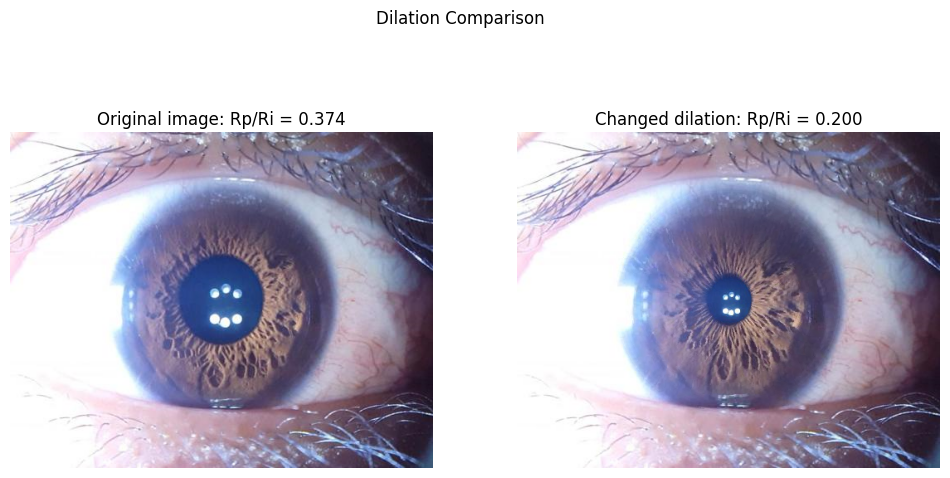

In [62]:
# Show results
fig, axs = plt.subplots(1,2, figsize=(12, 6))
fig.suptitle('Dilation Comparison')

axs[0].imshow(im1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original image: Rp/Ri = {:0.3f}'.format(original_pupil_radius/iris_radius))
#save in a file
im2.save('output.png')


axs[1].imshow(im2, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Changed dilation: Rp/Ri = {:0.3f}'.format(dil))

plt.show()

In [63]:
# store as a png image
im2.save(f'../samples/{img_name}_dilated_{dil}.png')